<a href="https://colab.research.google.com/github/sk-aili/market-basket-analysis/blob/main/Model_development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender System - Model Development


**Importing Libraries**

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.preprocessing import LabelEncoder
from mlxtend.frequent_patterns import fpgrowth
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [35]:
df = pd.read_csv("cleandf.csv")

In [36]:
df = df.iloc[:, 1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269720 entries, 0 to 269719
Data columns (total 77 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   product_id            269720 non-null  int64  
 1   time_id               269720 non-null  int64  
 2   customer_id           269720 non-null  int64  
 3   store_id              269720 non-null  int64  
 4   store_sales           269720 non-null  float64
 5   store_cost            269720 non-null  float64
 6   unit_sales            269720 non-null  int64  
 7   city                  269720 non-null  object 
 8   state_province        269720 non-null  object 
 9   country               269720 non-null  object 
 10  customer_region_id    269720 non-null  int64  
 11  yearly_income         269720 non-null  object 
 12  gender                269720 non-null  object 
 13  total_children        269720 non-null  int64  
 14  num_children_at_home  269720 non-null  int64  
 15  

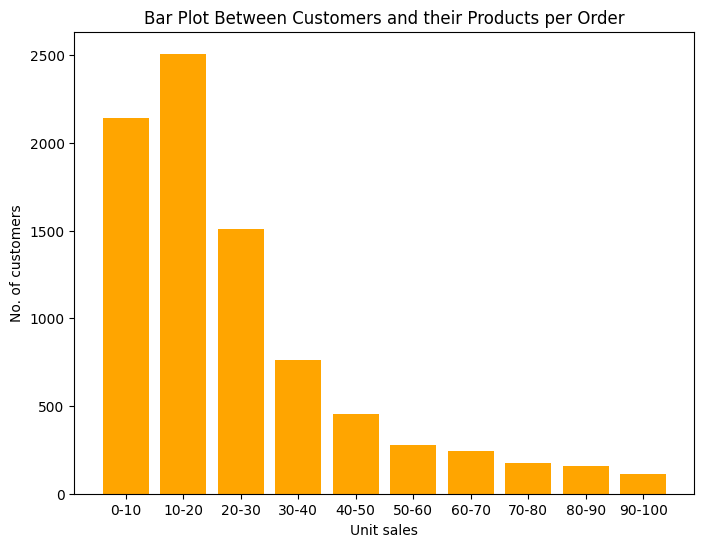

In [37]:
data_user_orders_num = df.groupby('customer_id')['unit_sales'].count()
source_data = {}
for i in range(10):
    source_data[str(10*i)+'-'+str(10*(i+1))]=len([x for x in list(data_user_orders_num) if x>=i*10 and x<(i+1)*10])

font_size=10
fig_size=(8,6)
mpl.rcParams['font.size']=font_size
mpl.rcParams['figure.figsize']=fig_size
bar_width=0.3
x_axis = tuple(source_data.keys())
y_axis = tuple(source_data.values())
#assign color
plt.bar(x_axis, y_axis, color='orange')
# descrpitions for x-axis, y-axis
plt.xlabel('Unit sales')
plt.ylabel("No. of customers")
plt.title("Bar Plot Between Customers and their Products per Order")
plt.show()

In [38]:
## Transaction ID - create transaction id which denotes a basket
df['transaction_id'] = df['customer_id'].astype(str) + df['time_id'].astype(str)
cols = [76,2,0,23]
order_products=df[df.columns[cols]]
## Average products bought by customers per order
data_user_products_num1=order_products.groupby('transaction_id')['product_id'].count()
data_user_products_num1=pd.DataFrame(data_user_products_num1)
data_user_products_num1['transaction_id']=list(data_user_products_num1.index)
data_user_products_num1.columns=['product_num','orderid']
data_user_products_num2=pd.merge(data_user_products_num1,df[['transaction_id','customer_id']],on='transaction_id',how='left')
data_user_products_num3=data_user_products_num2.groupby('customer_id')['product_num'].agg(['sum','count'])
data_user_products_num3['avg']=data_user_products_num3['sum']/data_user_products_num3['count']
data_user_products_num3.head()

,sum,count,avg
customer_id,,,
3,186,30,6.200000
5,1,1,1.000000
6,72,16,4.500000
8,208,42,4.952381
9,85,13,6.538462


In [39]:
# Featured Products
cols = [1,36,38,24]
departments=df[df.columns[cols]]
temp=['department']
produce=df.loc[df['department'] == 'Produce']
top_produce=produce['product_name'].value_counts().iloc[:10]
snacks=df.loc[df['department']=='Snack Foods']
top_snacks=snacks['product_name'].value_counts().iloc[:10]
household=df.loc[df['department']=='Household']
top_household=household['product_name'].value_counts().iloc[:10]
frozen=df.loc[df['department']=='Frozen Foods']
top_frozen=frozen['product_name'].value_counts().iloc[:10]
baking=df.loc[df['department']=='Baking Goods']
top_baking=baking['product_name'].value_counts().iloc[:10]
canned=df.loc[df['department']=='Canned Foods']
top_canned=canned['product_name'].value_counts().iloc[:10]
dairy=(df.loc[df['department'] == 'Dairy'])
top_dairy=dairy['product_name'].value_counts().iloc[:10]
dairy=(df.loc[df['department'] == 'Health and Hygiene'])
top_dairy=dairy['product_name'].value_counts().iloc[:10]
dairy=(df.loc[df['department'] == 'Beverages'])
top_dairy=dairy['product_name'].value_counts().iloc[:10]
dairy=(df.loc[df['department'] == 'Deli'])
top_dairy=dairy['product_name'].value_counts().iloc[:10]
dairy=(df.loc[df['department'] == 'Alcoholic Beverages'])
top_dairy=dairy['product_name'].value_counts().iloc[:10]
dairy=(df.loc[df['department'] == 'Starchy Foods'])
top_dairy=dairy['product_name'].value_counts().iloc[:10]
dairy=(df.loc[df['department'] == 'Eggs'])
top_dairy=dairy['product_name'].value_counts().iloc[:10]

In [40]:
## Top 100 most frequently purchased products
cols = [76,2,0,23,6,1]
product_name=df[df.columns[cols]]
productCountDf = product_name.groupby("product_id",as_index = False)['transaction_id'].count()
productCountDf = productCountDf.sort_values("transaction_id",ascending = False)
topProdFrame = productCountDf.iloc[0:100,:]
productId= topProdFrame.loc[:,["product_id"]]

In [41]:
## Orders containting the the most frequently purchased products
MarketBasketdf = product_name[0:0]
for i in range(0,99):
    pId = productId.iloc[i]['product_id']
    stDf = product_name[product_name.product_id == pId ]
    MarketBasketdf = MarketBasketdf.append(stDf,ignore_index = False)

basket = MarketBasketdf.groupby(['transaction_id','product_name'])['unit_sales'].sum().unstack().reset_index().fillna(0).set_index('transaction_id')

**One Hot Encoding**

In [42]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1


In [43]:
basket_sets = basket.applymap(encode_units)
dummy=basket_sets.head(10000)

**Apriori Algorithm & its Recommendations**

In [44]:
## Frequent items with support 0.01% using Apriori Algorithm
frequent_itemsets = apriori(dummy, min_support=0.0001, use_colnames=True)

In [45]:
apriori_rules = association_rules(frequent_itemsets, metric="lift", min_threshold= 1)
apriori_rules[ (apriori_rules['lift'] >= 50) & (apriori_rules['confidence'] >= 0.01) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
949,"(ADJ Rosy Sunglasses, Moms Potato Salad)",(Better Chicken Noodle Soup),0.0001,0.0120,0.0001,1.000000,83.333333,0.000099,inf,0.988099
950,"(Better Chicken Noodle Soup, ADJ Rosy Sunglasses)",(Moms Potato Salad),0.0001,0.0120,0.0001,1.000000,83.333333,0.000099,inf,0.988099
955,"(Better Chicken Noodle Soup, ADJ Rosy Sunglasses)",(Special Wheat Puffs),0.0001,0.0124,0.0001,1.000000,80.645161,0.000099,inf,0.987699
956,"(Special Wheat Puffs, ADJ Rosy Sunglasses)",(Better Chicken Noodle Soup),0.0001,0.0120,0.0001,1.000000,83.333333,0.000099,inf,0.988099
960,"(Better Fancy Canned Clams, Ebony Mixed Nuts)",(ADJ Rosy Sunglasses),0.0001,0.0112,0.0001,1.000000,89.285714,0.000099,inf,0.988899
...,...,...,...,...,...,...,...,...,...,...
2636,"(Great English Muffins, Super Grape Jam)","(Red Wing Tissues, Ebony Squash, Ebony Red Del...",0.0004,0.0001,0.0001,0.250000,2500.000000,0.000100,1.33320,1.000000
2637,"(Great English Muffins, Ebony Red Delcious App...","(Red Wing Tissues, Ebony Squash, Super Grape Jam)",0.0002,0.0001,0.0001,0.500000,5000.000000,0.000100,1.99980,1.000000
2638,"(Red Wing Tissues, Super Grape Jam)","(Ebony Red Delcious Apples, Ebony Squash, Grea...",0.0001,0.0001,0.0001,1.000000,10000.000000,0.000100,inf,1.000000
2639,"(Red Wing Tissues, Ebony Red Delcious Apples)","(Ebony Squash, Super Grape Jam, Great English ...",0.0001,0.0001,0.0001,1.000000,10000.000000,0.000100,inf,1.000000


In [46]:
def recommendations_using_Apriori(item):
    recommend = []
    for i in range(0,2646):
        if item == apriori_rules.iloc[i,0]:
            recommend.append(apriori_rules.iloc[i,1])

    return recommend

In [47]:
## 5 Recommendations with Better Chicken Noodle Soup
product_name = {'Better Chicken Noodle Soup'}
recommentations=recommendations_using_Apriori(product_name)
print(*recommentations[0:5], sep = "\n")

frozenset({'Better Chicken Ramen Soup'})
frozenset({'Carlson Blueberry Yogurt'})
frozenset({'Framton City Map'})
frozenset({'Hermanos Green Pepper'})
frozenset({'Hilltop Extra Moisture Shampoo'})


In [48]:
## 10 Recommendations with Moms Potato Salad
product_name = {'Moms Potato Salad'}
recommentations=recommendations_using_Apriori(product_name)
print(*recommentations[0:10], sep = "\n")

frozenset({'Better Chicken Noodle Soup'})
frozenset({'Big Time Frozen Cheese Pizza'})
frozenset({'Framton City Map'})
frozenset({'Great Pumpernickel Bread'})
frozenset({'Hermanos Green Pepper'})
frozenset({'Hilltop Extra Moisture Shampoo'})
frozenset({'Hilltop Silky Smooth Hair Conditioner'})
frozenset({'Moms Roasted Chicken'})
frozenset({'Nationeel Grape Fruit Roll'})
frozenset({'Red Wing 60 Watt Lightbulb'})


In [49]:
## 15 Recommendations with Carrington Ice Cream Sandwich
product_name = {'Carrington Ice Cream Sandwich'}
recommentations=recommendations_using_Apriori(product_name)
print(*recommentations[0:15], sep = "\n")

frozenset({'Better Fancy Canned Anchovies'})
frozenset({'Fabulous Cranberry Juice'})
frozenset({'Great English Muffins'})
frozenset({'Hermanos Mandarin Oranges'})
frozenset({'Hermanos Squash'})
frozenset({'Hermanos Tomatos'})
frozenset({'Just Right Turkey Noodle Soup'})
frozenset({'Sunset Economy Toilet Brush'})
frozenset({'Better Canned Tuna in Oil', 'Just Right Turkey Noodle Soup'})
frozenset({'Fabulous Apple Juice', 'Better Fancy Canned Anchovies'})
frozenset({'Better Fancy Canned Anchovies', 'Fabulous Cranberry Juice'})
frozenset({'Framton City Map', 'Booker 1% Milk'})
frozenset({'Steady Childrens Cold Remedy', 'Carlson Jack Cheese'})
frozenset({'Carrington Beef TV Dinner', 'Denny 60 Watt Lightbulb'})


**Fpgrowth Algorithm & its Recommendations**

In [50]:
## Frequent Items with support 0.001% using Fpgrowth Algorithm
freq_items=fpgrowth(dummy,min_support=.0001,use_colnames=True)
## Association Rules using Fpgrowth Algorithm
fpgrowth_rules=association_rules(freq_items,metric="lift",min_threshold=1)

In [51]:
def recommendations_using_Fpgrowth(item):
    recommend = []
    for i in range(0,2646):
        if item == fpgrowth_rules.iloc[i,0]:
            recommend.append(fpgrowth_rules.iloc[i,1])

    return recommend

In [52]:
## 5 Recommendations with Better Chicken Noodle Soup
product_name = {'Better Chicken Noodle Soup'}
recommentations=recommendations_using_Fpgrowth(product_name)
print(*recommentations[0:5], sep = "\n")

frozenset({'Moms Potato Salad'})
frozenset({'Special Wheat Puffs', 'Moms Potato Salad'})
frozenset({'Sunset Large Sponge'})
frozenset({'Sunset Large Sponge', 'Better Chicken Ramen Soup'})
frozenset({'Special Wheat Puffs'})


In [53]:
## 10 Recommendations with Moms Potato Salad
product_name = {'Moms Potato Salad'}
recommentations=recommendations_using_Fpgrowth(product_name)
print(*recommentations[0:10], sep = "\n")

frozenset({'Better Chicken Noodle Soup'})
frozenset({'Framton City Map'})
frozenset({'Great Pumpernickel Bread'})
frozenset({'Hilltop Extra Moisture Shampoo'})
frozenset({'Red Wing 60 Watt Lightbulb'})
frozenset({'Steady 200 MG Acetominifen'})
frozenset({'Big Time Frozen Cheese Pizza'})
frozenset({'Hilltop Silky Smooth Hair Conditioner'})
frozenset({'Hermanos Green Pepper'})
frozenset({'Better Chicken Noodle Soup', 'Special Wheat Puffs'})


In [54]:
## 15 Recommendations with Carrington Ice Cream Sandwich
product_name = {'Carrington Ice Cream Sandwich'}
recommentations=recommendations_using_Fpgrowth(product_name)
print(*recommentations[0:15], sep = "\n")

frozenset({'Fabulous Cranberry Juice'})
frozenset({'Better Fancy Canned Anchovies', 'Fabulous Cranberry Juice'})
frozenset({'Hermanos Mandarin Oranges'})
frozenset({'Hermanos Tomatos'})
frozenset({'Hermanos Squash'})
frozenset({'Sunset Economy Toilet Brush'})
frozenset({'Better Fancy Canned Anchovies'})
frozenset({'Just Right Turkey Noodle Soup'})
frozenset({'Great English Muffins'})
frozenset({'Carrington Beef TV Dinner', 'Denny 60 Watt Lightbulb'})
frozenset({'Steady Childrens Cold Remedy', 'Carlson Jack Cheese'})
frozenset({'Framton City Map', 'Booker 1% Milk'})
frozenset({'Better Canned Tuna in Oil', 'Just Right Turkey Noodle Soup'})
frozenset({'Fabulous Apple Juice', 'Better Fancy Canned Anchovies'})


**Apriori vs fpgrowth Algorithm: Performance measure**

In [55]:
## Calculating Run Time of Apriori Algorithm
import time
l=[0.01,0.02,0.03,0.04,0.05]
t=[]
for i in l:
    t1=time.time()
    apriori(dummy,min_support=i,use_colnames=True)
    t2=time.time()
    t.append((t2-t1)*1000)

In [56]:
## Calculating Run Time of Fpgrowth Algorithm
l=[0.01,0.02,0.03,0.04,0.05]
f=[]
for i in l:
    t1=time.time()
    fpgrowth(dummy,min_support=i,use_colnames=True)
    t2=time.time()
    f.append((t2-t1)*1000)

**Graph of Run Time between Apriori and Fpgrowth Algorithm**

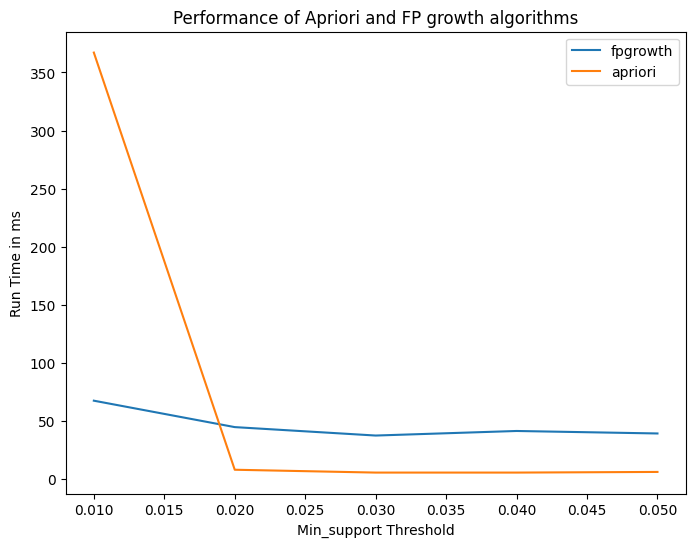

In [57]:
sns.lineplot(x=l,y=f,label="fpgrowth")
sns.lineplot(x=l,y=t,label="apriori")
plt.title("Performance of Apriori and FP growth algorithms")
plt.xlabel("Min_support Threshold")
plt.ylabel("Run Time in ms")
plt.show()

Comments: For low support values, Apriori is taking more time while FP growth is performing well.

**Thank You**